# Comparison of Binary Classifiers

## 1. About the Dataset

`Wheat Seeds` dataset is an agricultural dataset from the UCI Machine Learning Repository. This dataset contains measurements of seeds from different varieties of wheat. There are `210` observations with `7` input variables and `1` output variable. The input variables are:
- area
- perimeter
- compactness
- length of kernel
- width of kernel
- asymmetry coefficient
- length of kernel groove

There are three classes, corresponding to three wheat types: `Canadian`, `Koma`, and `Rosa`,  `70` elements each (Seeds dataset n.d.). This is a very recent dataset and its features were automatically computed from digital images (Richert and Coelho 2013).

## 2. The Approach and Questions

The goal is to train a binary classification model to predict species given morphological measurements of seeds from different varieties of wheat.

The `type` column is the *dependent variable* or *target* for classification, while all other columns are the *predictors*. In the training process, the dataset will be split into a training set and a test set. The training set will be further split (multiple times) into a training and validation set in a cross-validation procedure for tuning the parameters of four alternative classifiers: 
- `Support Vector Machine (SVM)` 
- `Random Forest`
- `K-Nearest Neighbours (KNN)`
- `AdaBoost`

In the `seeds` dataset, the `type` attribute with the range of values 1, 2 and 3 determines the type of wheat seed. Binary classifiers require the `type` to be binary (0 or 1). Therefore, we have to transform the `type` column accordingly. Here, we will explore two possible approaches: 
- `Imbalanced dataset` - we keep all the data, map one of the types to 1 and the other two to 0. As a result, we will have 70 elements of type 1 and 140 elements of type 0.
- `Balanced dataset` - we drop one of the types and map the other two types - one to 1 and the other one to 0. As a result, we will have 70 elements of type 1 and 70 elements of type 0.


The questions to be answered:
- How do `SVM`, `Random Forest`, `KNN` and `AdaBoost` classifiers compare when trained with the `seeds` dataset?
- Do these four classifiers perform better on a balanced or imbalanced dataset?

## 3. Import Python Modules

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import neighbors, svm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from scipy import interp

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# overwrite Matplotlib's default parameters by seting the style 
# by calling Seaborn's set() method
sns.set()

## 4. Load the Dataset

In [3]:
df = pd.read_csv("./seeds.csv")

## 5. Exploratory Data Analysis

### 5.1 Dimensions of the Dataset

In [4]:
# Print the dimensions of the dataset
df.shape

(210, 8)

The `seeds` dataset has __210__ data rows, and it contains __8__ attributes.

### 5.2 Quick Data Exploration

In [5]:
# Print the last 10 rows of the dataframe
df.tail(10)

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
200,12.38,13.44,0.8609,5.219,2.989,5.472,5.045,3
201,12.67,13.32,0.8977,4.984,3.135,2.300,4.745,3
202,11.18,12.72,0.8680,5.009,2.810,4.051,4.828,3
203,12.70,13.41,0.8874,5.183,3.091,8.456,5.000,3
204,12.37,13.47,0.8567,5.204,2.960,3.919,5.001,3
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


The `seeds` dataset contains only numerical attributes.
The last attribute `type` indicates the type of seed. This attribute is a primary candidate for an attribute to learn to predict from the values of the other attributes.

### 5.3 Check for missing values

First, we check for missing values.

In [6]:
# Find the number of nulls in the dataset
df.isnull().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values in the `seeds` dataset.

### 5.4 Check for duplicates

We can also check if there are any duplicated rows in the dataset.

In [7]:
# Find duplicates in the dataset

data_dup = df[df.duplicated(keep="last")]
data_dup

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type


There are no duplicates in the `seeds` dataset.

### 5.5 Summary of the dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   area                     210 non-null    float64
 1   perimeter                210 non-null    float64
 2   compactness              210 non-null    float64
 3   length of kernel         210 non-null    float64
 4   width of kernel          210 non-null    float64
 5   asymmetry coefficient    210 non-null    float64
 6   length of kernel groove  210 non-null    float64
 7   type                     210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


### 5.6 Class Distribution

The examination of the class distribution allows us to determine whether the data in the `seeds` dataset is balanced or not.

In [9]:
# Print the class distribution
df.groupby('type').size()

type
1    70
2    70
3    70
dtype: int64

We can determine that each class has the same number of instances - __70__.

### 5.7 Check for outliers

Next, we check the boxplots of the numerical columns for outliers. We will do this in three slices.

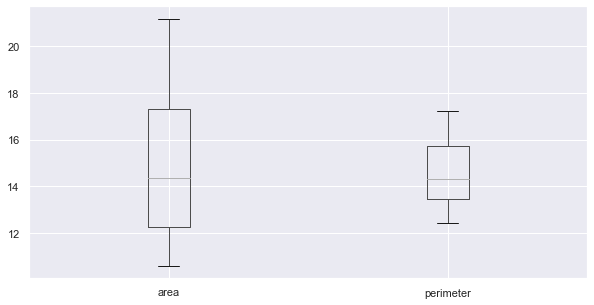

In [10]:
df.loc[:,'area':'perimeter'].boxplot(figsize=(10,5))
plt.show()

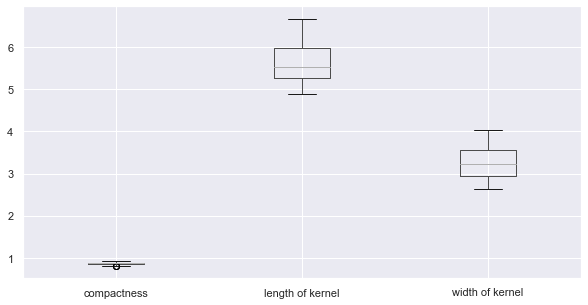

In [11]:
df.loc[:,'compactness':'width of kernel'].boxplot(figsize=(10,5))
plt.show()

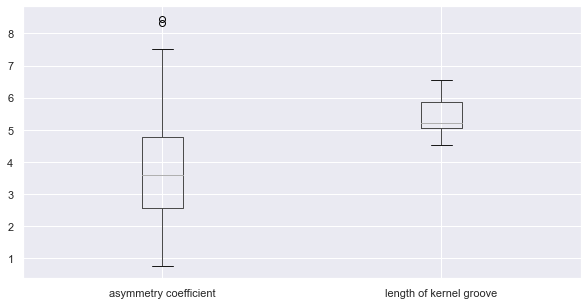

In [12]:
df.loc[:,'asymmetry coefficient':'length of kernel groove'].boxplot(figsize=(10,5))
plt.show()

The `asymmetry coefficient` column contains outliers. We will apply log transformation followed by RobustScaler to that column. To all other predictor columns, we will apply StandardScaler.

## 6. Making a Copy of the Dataset

Before we start transforming the `seeds` dataset, we make a copy of it.

In [13]:
df_original = df

## 7. Imbalanced dataset

In the `seeds` dataset, the `type` attribute with the range of values 1, 2 and 3 determines the type of wheat seed. Binary classifiers require the type to be binary (0 or 1). Therefore, we have to transform the `type` column accordingly. 

The first approach we will explore is creating an `imbalanced dataset`. We will keep all the data, map one of the types to 1 and the other two to 0. As a result, we will have 70 elements of type 1 and 140 elements of type 0.

### 7.1 Data Preparation

First, we transform the `type` column.

In [14]:
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

The `type` column identifies the three different types of wheat seeds and is the principal column for classification. Instead of dropping one type at random, we will map one of the types to 1 and the other two to 0. This way, we will keep all the data.

In [15]:
# Create a mapper
type_mapper = {
    1:1,
    2:0,
    3:0
}

df['type'] = df['type'].replace(type_mapper)
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

Now we have only two types: 0 and 1.

Next, we need to prepare two lists of column names. The list `names_outliers` contains the names of the columns to which we will apply `log transformation` followed by `RobustScaler`. The list `names_no_outliers` contains the names of all other predictor columns to which we will apply `StandardScaler`.

In [16]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, we stored the names of the columns in the lists above.

Next, we create a class that will be used in the preprocessing pipeline to put the names of the columns back. We need this to easily apply the different preparation strategies to the two groups of columns.

In [17]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then we need another class to be able to select a particular group of columns.

In [18]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Finally, we can build the preprocessing pipeline. It first adds the column names back to a set of examples. Then it applies the two different data preparation strategies to the two groups of columns and unites them with `FeatureUnion`.

In [19]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Now we can separate the columns into `target` and `predictors` and split the dataset into `training` and `test` sets.

In [20]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

The parameter `stratify=y` ensures both classes are represented in the same proportion in both the training and the test sets.

### 7.2 Grid Search for Best Parameters of Classifiers

Next, we train an `SVM` classifier with the training set and a range of possible parameters to find the best parameters for `SVM` by cross-validation.

In [21]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.947:
Best parameters:  {'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


The parameter `refit=True` makes the GridSearchCV train an `SVM` classifier on the __entire training set__ with the best parameters found. This best SVM model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.

Next, we repeat the same experiment with the `Random Forest` classifier.

In [22]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
param_grid = {
    'rf__bootstrap': [True, False],
    'rf__max_depth': [2, 4, 6, 8, 10, 20, None],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__min_samples_leaf': [1, 2, 4, 5],
    'rf__min_samples_split': [2, 5, 10],
    'rf__n_estimators': [10, 20, 30, 40, 50, 60]
}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.923:
Best parameters:  {'rf__bootstrap': False, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 20}


### 7.3 Compare Classifiers on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test dataset. The results returned by the function are a variety of metrics measured on the test set, which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:
- `accuracy`
- `precision`
- `recall`
- `F1-score`
- `TPR` (true positive rate)
- `AUC` (area under the ROC curve)

To plot `ROC curves` for the models, we need to ensure that the same `FPR` (false positive rate) scale is used for all curves. For this reason, we take a scale of 100 equally spaced `FPR` values between 0 and 1.

In [23]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [24]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

Now we will use the function above to evaluate the best `SVM` and `Random Forest` models found by the grid search.

In [25]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

We will use a pandas `bar plot` to compare the `accuracy` of both models as well as their `precision`, `recall` and `F1-score` for class 1.

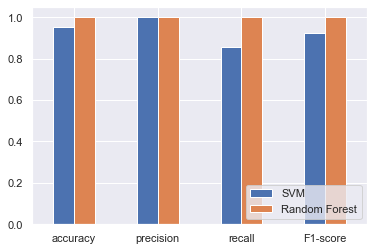

In [26]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Both classifiers perform well with `Random Forest` being slightly better.

We can also examine the `ROC curves` of the two classifiers for `class 1`.

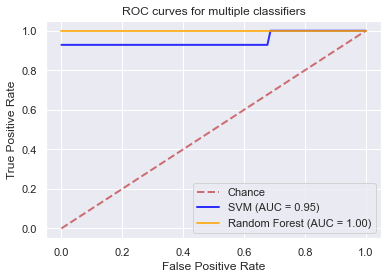

In [27]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The `ROC curves` confirm that both classifiers (`SVM` and `Random Forest`) perform significantly better than a random guess (the red dashed line).

### 7.4 The Other Classifiers

The two additional classifiers are `K-Nearest Neighbors (KNN)` and `AdaBoost`.

### 7.5 Grid Search for Best Parameters of Classifiers

First, we train a `KNN` classifier with the training set and a range of possible parameters to find the best parameters for `KNN` by cross-validation.

In [28]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', neighbors.KNeighborsClassifier())])

# prepare a prameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10, 15, 20],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [3, 5, 10, 15],
    'knn__p': [1, 2]}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.928:
Best parameters:  {'knn__algorithm': 'auto', 'knn__leaf_size': 3, 'knn__n_neighbors': 3, 'knn__p': 2}


Next, we repeat the same experiment with the `AdaBoost` classifier.

In [29]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('ab', AdaBoostClassifier())])

# prepare a prameter grid
param_grid = {
    'ab__n_estimators': [10, 20, 30, 50, 70, 100],
    'ab__random_state': [0, 1]}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
AB_best_params = search.best_params_
AB_best_model = search.best_estimator_

Best CV score = 0.911:
Best parameters:  {'ab__n_estimators': 50, 'ab__random_state': 0}


### 7.6 Compare Classifiers on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results to choose the better classifier for our problem.

We will use the `evaluate_model` function to evaluate the best `KNN` and `AdaBoost` models found by the grid search.

In [30]:
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)
AB_accuracy, AB_precision, AB_recall, AB_f1_score, AB_tpr, AB_auc = evaluate_model(X_test, y_test, AB_best_model)

We will use a pandas `bar plot` to compare the `accuracy` of all four models as well as their `precision`, `recall` and `F1-score` for class 1.

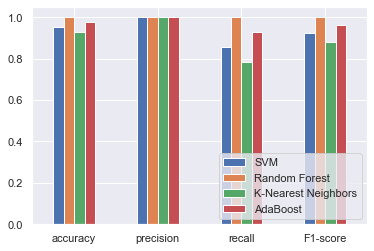

In [31]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
AB_metrics = np.array([AB_accuracy, AB_precision, AB_recall, AB_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'K-Nearest Neighbors': KNN_metrics, 'AdaBoost': AB_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

We can also examine the `ROC curves` of all four classifiers for class 1.

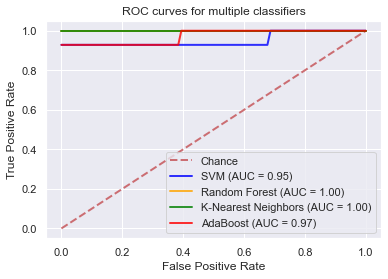

In [32]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='green', label='K-Nearest Neighbors (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.plot(mean_fpr, AB_tpr[0,:], lw=2, color='red', label='AdaBoost (AUC = %0.2f)' % (AB_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

### 7.7 Train the Final Model

The `Random Forest` classifier achieved the highest accuracy, precision, recall and F1 score. Therefore, it has been selected to train the final model with all data we have, assuming that the more data we have, the better the model.

In [33]:
# function to remove the string 'rf__' from the names of the parameters in RF_best_params
def transform(dict):
    return {key.replace('rf__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, RandomForestClassifier(**transform(RF_best_params)))

final_model = pipe.fit(X, y)

Finally, we store the model on disk.

In [34]:
filename = 'final_model_1.sav'
pickle.dump(final_model, open(filename, 'wb'))

## 8. Balanced dataset

In the `seeds` dataset, the `type` attribute with the range of values 1, 2 and 3 determines the type of wheat seed. Binary classifiers require the type to be binary (0 or 1). Therefore, we have to transform the `type` column accordingly. 

The second approach we will explore is creating a `balanced dataset`. We will drop one of the types and map the other two types - one to 1 and the other one to 0. As a result, we will have 70 elements of type 1 and 70 elements of type 0.

### 8.1 Data Preparation

First, we load the `seeds` dataset again.

In [35]:
df = pd.read_csv("./seeds.csv")

Next, we transform the `type` column.

In [36]:
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

The `type` column identifies the three different types of wheat seeds and is the principal column for classification. We will drop one of the types and map the other two types - one to 1 and the other one to 0.

In [37]:
df = df[df.type != 3]

In [38]:
df['type'].value_counts()

2    70
1    70
Name: type, dtype: int64

In [39]:
# Create a mapper
type_mapper = {
    1:1,
    2:0
}

df['type'] = df['type'].replace(type_mapper)
df['type'].value_counts()

1    70
0    70
Name: type, dtype: int64

Now we have only two types: 0 and 1.

Next, we need to prepare two lists of column names. The list `names_outliers` contains the names of the columns to which we will apply `log transformation` followed by `RobustScaler`. The list `names_no_outliers` contains the names of all other predictor columns to which we will apply `StandardScaler`.

In [40]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, we stored the names of the columns in the lists above.

Next, we can build the preprocessing pipeline. It first adds the column names back to a set of examples (that can be either a training, validation or test set). Then it applies the two different data preparation strategies to the two groups of columns and unites them with `FeatureUnion`.

In [41]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Now we can separate the columns into `target` and `predictors` and split the dataset into `training` and `test` sets.

In [42]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

The parameter `stratify=y` ensures both classes are represented in the same proportion in both the training and the test sets.

### 8.2 Grid Search for Best Parameters of Classifiers

Next, we train the `SVM` classifier with the training set and a range of possible parameters to find the best parameters for `SVM` by cross-validation.

In [43]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.983:
Best parameters:  {'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


Next, we repeat the same experiment with the `Random Forest` classifier.

In [44]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
param_grid = {
    'rf__bootstrap': [True, False],
    'rf__max_depth': [2, 4, 6, 8, 10, 20, None],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__min_samples_leaf': [1, 2, 4, 5],
    'rf__min_samples_split': [2, 5, 10],
    'rf__n_estimators': [10, 20, 30, 40, 50, 60]
}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.983:
Best parameters:  {'rf__bootstrap': True, 'rf__max_depth': 2, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 5, 'rf__n_estimators': 20}


### 8.3 Compare Classifiers on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results to choose the better classifier for our problem.

To plot `ROC curves` for the models, we need to ensure that the same `FPR` (false positive rate) scale is used for all curves. For this reason, we take a scale of 100 equally spaced `FPR` values between 0 and 1.

In [45]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

Now we will use the `evaluate_model` function to evaluate the best `SVM` and `Random Forest` models found by the grid search.

In [46]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

We will use a pandas `bar plot` to compare the `accuracy` of both models as well as their `precision`, `recall` and `F1-score` for class 1.

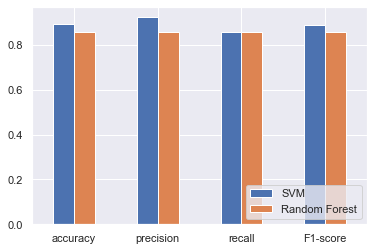

In [47]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Both classifiers perform well with `SVM` being slightly better.

We can also examine the `ROC curves` of the two classifiers for class 1.

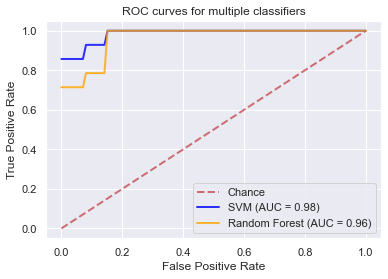

In [48]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The `ROC curves` confirm that both classifiers (`SVM` and `Random Forest`) perform significantly better than a random guess (the red dashed line).

### 8.4 The Other Classifiers

The two additional classifiers are `K-Nearest Neighbors (KNN)` and `AdaBoost`.

### 8.5 Grid Search for Best Parameters of Classifiers

First, we train the `KNN` classifier with the training set and a range of possible parameters to find the best parameters for `KNN` by cross-validation.

In [49]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', neighbors.KNeighborsClassifier())])

# prepare a prameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10, 15, 20],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [3, 5, 10, 15],
    'knn__p': [1, 2]}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.983:
Best parameters:  {'knn__algorithm': 'auto', 'knn__leaf_size': 3, 'knn__n_neighbors': 20, 'knn__p': 1}


Next, we repeat the same experiment with the `AdaBoost` classifier.

In [50]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('ab', AdaBoostClassifier())])

# prepare a prameter grid
param_grid = {
    'ab__n_estimators': [10, 20, 30, 50, 70, 100],
    'ab__random_state': [0, 1]}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
AB_best_params = search.best_params_
AB_best_model = search.best_estimator_

Best CV score = 0.975:
Best parameters:  {'ab__n_estimators': 70, 'ab__random_state': 0}


### 8.6 Compare Classifiers on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results to choose the better classifier for our problem.

We will use the `evaluate_model` function to evaluate the best `KNN` and `AdaBoost` models found by the grid search.

In [51]:
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)
AB_accuracy, AB_precision, AB_recall, AB_f1_score, AB_tpr, AB_auc = evaluate_model(X_test, y_test, AB_best_model)

We will use a pandas `bar plot` to compare the `accuracy` of all four models as well as their `precision`, `recall` and `F1-score` for class 1.

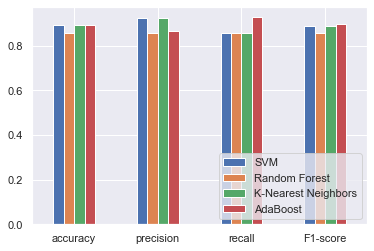

In [52]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
AB_metrics = np.array([AB_accuracy, AB_precision, AB_recall, AB_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'K-Nearest Neighbors': KNN_metrics, 'AdaBoost': AB_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

We can also examine the `ROC curves` of all four classifiers for class 1.

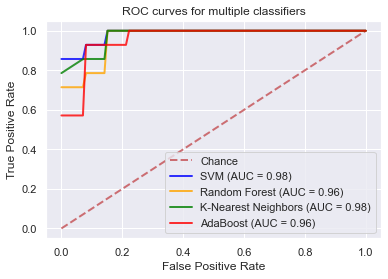

In [53]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='green', label='K-Nearest Neighbors (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.plot(mean_fpr, AB_tpr[0,:], lw=2, color='red', label='AdaBoost (AUC = %0.2f)' % (AB_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

### 8.7 Train a Final Model

The `SVM` classifier achieved the highest accuracy, precision and F1 score. Therefore, it has been selected to train the final model with all data we have, assuming that the more data we have, the better the model.

In [54]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model = pipe.fit(X, y)

Finally, we store the model on disk.

In [55]:
filename = 'final_model_2.sav'
pickle.dump(final_model, open(filename, 'wb'))

## 9. Conclusion

All four examined classifiers - `SVM`, `Random Forest`, `KNN` and `AdaBoost` performed very well on both `balanced` (70 elements of type 1 and 70 elements of type 0) and `imbalanced` (70 elements of type 1 and 140 elements of type 0) `seeds` dataset, with slightly better results on the balanced dataset.

__Imbalanced dataset__

The examined classifiers achieved the following best CV scores:
- `SVM` - 0.947
- `Random Forest` - 0.923
- `KNN` - 0.928
- `AdaBoost` - 0.911

The ROC curves confirmed that all four classifiers performed significantly better than a random guess:
- `SVM` - AUC = 0.95
- `Random Forest` - AUC = 1.00
- `KNN` - AUC = 1.00
- `AdaBoost` - AUC = 0.97

The `Random Forest` classifier, in addition to the best AUC result, achieved the highest `accuracy`, `precision`, `recall` and `F1 score`. Therefore, it was selected to train a final model on the entire dataset (imbalanced).

__Balanced dataset__

The examined classifiers achieved the following best CV scores:
- `SVM` - 0.983
- `Random Forest` - 0.983
- `KNN` - 0.983
- `AdaBoost` - 0.975

The ROC curves confirmed that all four classifiers performed significantly better than a random guess:
- `SVM` - AUC = 0.98
- `Random Forest` - AUC = 0.96
- `KNN` - AUC = 0.98
- `AdaBoost` - AUC = 0.96

The `SVM` classifier, in addition to the best AUC result, achieved the highest `accuracy`, `precision` and `F1 score`. Therefore, it was selected to train a final model on the entire dataset (balanced).

## References

Richert, W. and Coelho, L.P. (2013) *Building Machine Learning Systems with Python*, Birmingham: Packt Publishing.

*Seeds dataset* (n.d.) UCI Machine Learning Repository, available: https://archive.ics.uci.edu/ml/datasets/seeds [accessed 19 Apr 2020].

*sklearn.ensemble.AdaBoostClassifie* (n.d.) Scikit Learn 0.22.2 documentation, available: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier [accessed 18 Apr 2020].

*sklearn.ensemble.RandomForestClassifier* (n.d.) Scikit Learn 0.22.2 documentation, available: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html [accessed 18 Apr 2020].

*sklearn.neighbors.KNeighborsClassifier* (n.d.) Scikit Learn 0.22.2 documentation, available: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html [accessed 18 Apr 2020].

*sklearn.svm.SVC* (n.d.) Scikit Learn 0.22.2 documentation, available: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html [accessed 18 Apr 2020].